<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Multivariate-toy-example" data-toc-modified-id="Multivariate-toy-example-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Multivariate toy example</a></span></li><li><span><a href="#Train-test-split" data-toc-modified-id="Train-test-split-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Train test split</a></span></li><li><span><a href="#Proposal-of-general-Reducer-class" data-toc-modified-id="Proposal-of-general-Reducer-class-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Proposal of general Reducer class</a></span></li><li><span><a href="#ReducedMultivariateForecaster" data-toc-modified-id="ReducedMultivariateForecaster-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>ReducedMultivariateForecaster</a></span></li><li><span><a href="#Tunning-each-regressor-in-the-Reducer-individually" data-toc-modified-id="Tunning-each-regressor-in-the-Reducer-individually-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Tunning each regressor in the Reducer individually</a></span></li></ul></div>

## Multivariate toy example


Data `DailyDelhiClimateTrain.csv` from

https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data/version/1/tasks

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sktime
sktime.__version__

'0.4.3'

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("./data/DailyDelhiClimateTrain.csv")

In [5]:
cols = df.columns

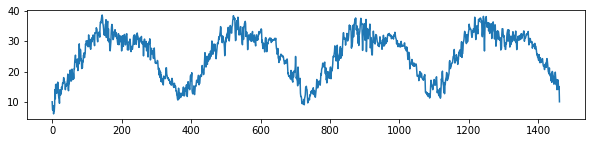

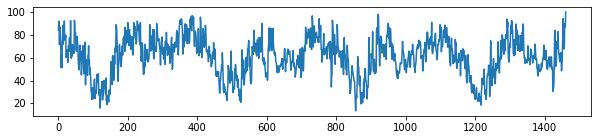

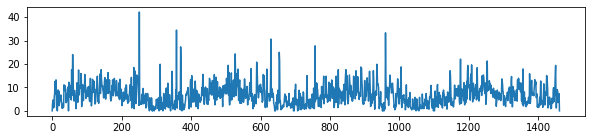

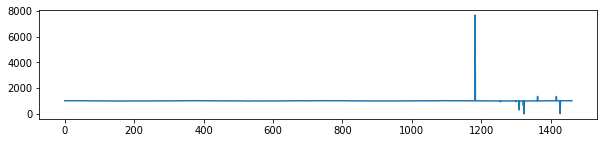

In [6]:
for col in cols:
    plt.figure(figsize=(10,2))
    plt.plot(df[col])

## Train test split

In [7]:
n_samples = len(df)
train_size_percentage = 0.75
train_size = int(n_samples * train_size_percentage)
test_size = n_samples - train_size
fh = np.arange(test_size) + 1
assert len(fh) == test_size, "fh should be equal to the length of the test set"

1096 366


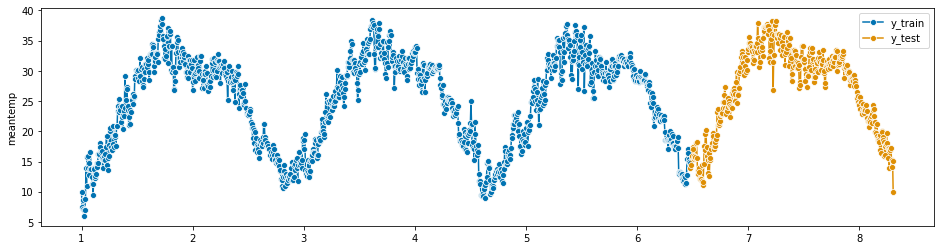

In [8]:
y_train, y_test = temporal_train_test_split(df[cols[0]], test_size=test_size)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

Here we should update `temporal_train_test_split` to handle dataframes.

df_train, df_test = temporal_train_test_split(df, test_size=test_size)

In [9]:
def temporal_train_test_split(df, test_size):
    if isinstance(df, pd.DataFrame):
        df_train = df[0:-test_size]
        df_test = df[-test_size:]
        return df_train, df_test
    

In [10]:
df_train, df_test = temporal_train_test_split(df, test_size=test_size)

## Proposal of general Reducer class

The following class can be used to learn from a  dataframe storing a multivariate timeseries

In [11]:
from sktime.forecasting.naive import NaiveForecaster
import copy

In [40]:
def _check_forecaster(forecaster):
    # check forecaster is univariate forecaster
    pass


class Reducer:
    """
    Class for using several copies of the same univariate forecaster 
    for each of the columns in the input data.
    
    This class reduces the multivariate forecasting problem to an
    `n_variables` forecasting problem.
    """
    
    def __init__(self, forecaster):
        self.forecaster = forecaster
        
    def fit(self, Y, X=None, fh=None):
        self.n_variables = Y.shape[1]
        self.forecasters_ = []
        self.last_index = Y.index[-1]
        self.columns = Y.columns
        
        for i, col in enumerate(Y):
            f = copy.deepcopy(self.forecaster)
            f.fit(Y[col])
            self.forecasters_.append(f)
                 
        self._is_fitted = True
        return self
            
    def predict(self, fh=None, X=None):
        y = np.empty((len(fh), self.n_variables))
        
        for i, f in enumerate(self.forecasters_):
            y[:, i] = f.predict(fh)
                    
        index_ = pd.RangeIndex(start=self.last_index,stop=self.last_index+len(fh),step=1)
        df_pred =  pd.DataFrame(y, index= index_,columns=self.columns) 
       
        return df_pred
    
    def update(self, Y, X=None):
        # online learning
        for f in enumerate(self.forecasters_):
            f.update(y, X=None)
            
        return self

    def get_params(self, deep=True):
        """
        get_params(deep=True) method of sktime.forecasting.Reducer instance
        Get parameters for this estimator. That is, a list of parameters for each estimator 
        in the .forecasters_ list.

        Parameters
        ----------
        deep : bool, default=True
            If True, will return the parameters for this estimator and
            contained subobjects that are estimators.

        Returns
        -------
        params : list of mapping of string to any
                 List containing dicts with parameter names mapped to their values.

        """
        #params = []
        #for forecaster in self.forecasters_:
        #    params.append(forecaster.get_params(deep=True))
        
        params = {}
        for i, forecaster in enumerate(self.forecasters_):
            params[str(i)] = forecaster.get_params(deep=True)
        
        
        return params

In [41]:
uf = NaiveForecaster()

multivariate_reducer = Reducer(uf)
multivariate_reducer.fit(df_train)
df_pred = multivariate_reducer.predict(fh)

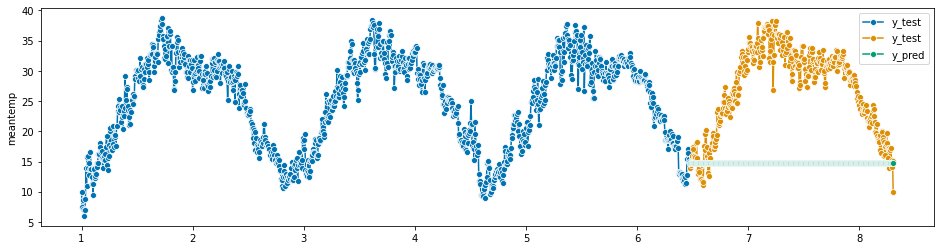

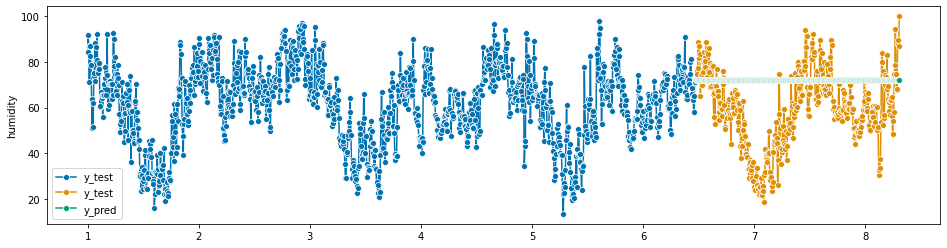

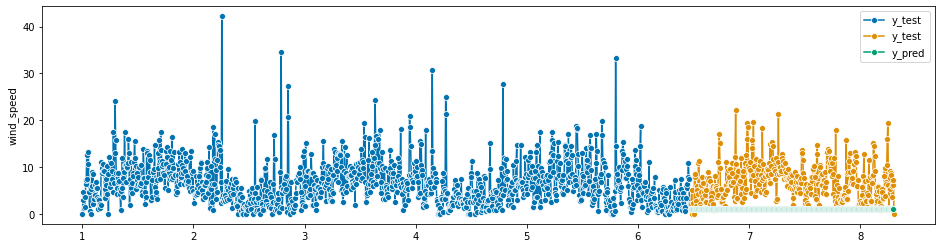

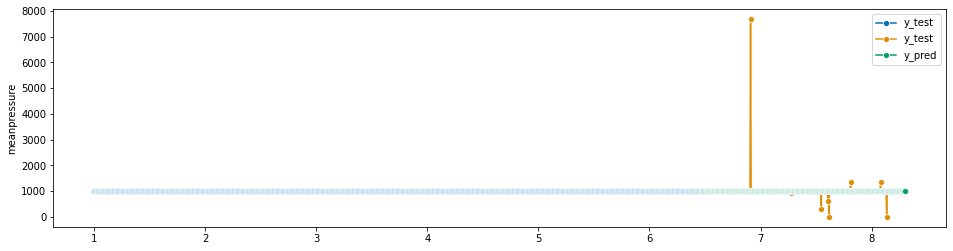

In [14]:
for col in cols:
    #plt.figure(figsize=(10,1))
    plot_series(df_train[col], 
                df_test[col],
                df_pred[col],
                labels=[ "y_test", "y_test","y_pred"])

We can "zoom in" and visualize only the test data

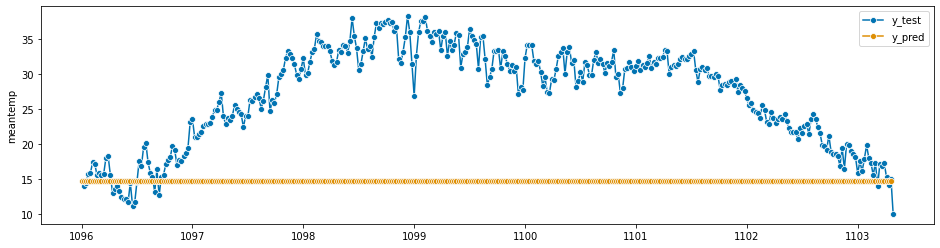

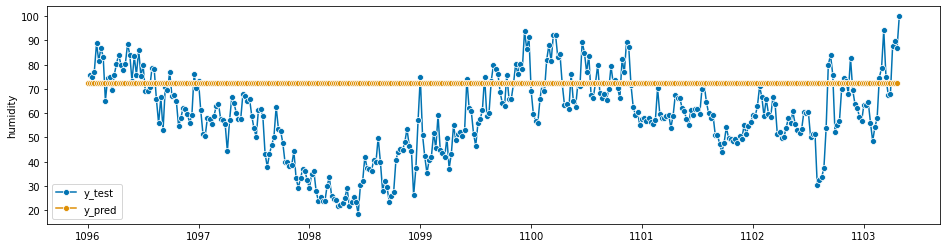

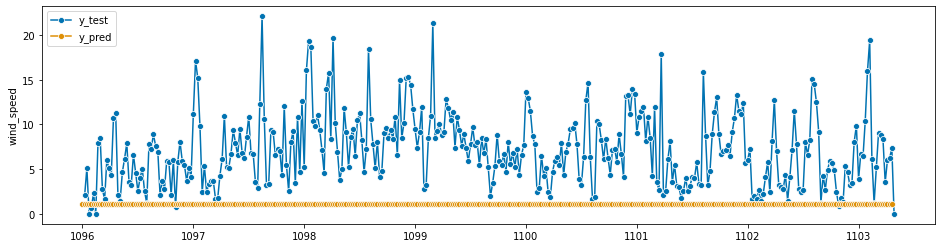

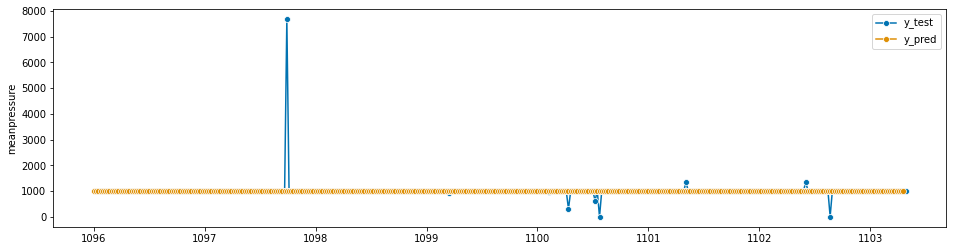

In [15]:
for col in cols:
    #plt.figure(figsize=(10,1))
    plot_series(df_test[col], 
                df_pred[col],
                labels=[ "y_test", "y_pred"])

## ReducedMultivariateForecaster

Instead of copying the same foreaster for each variable we can pass a list specifying a forecaster per variable

In [42]:


class ReducedMultivariateForecaster:
    """
    Class for using several copies of the same univariate forecaster 
    for each of the columns in the input data.
    
    This class reduces the multivariate forecasting problem to an
    `n_variables` forecasting problem.
    """
    
    def __init__(self, forecasters):
        self.forecasters = forecasters
        
    def fit(self, Y, X=None, fh=None):
        
        assert isinstance(Y,pd.DataFrame),\
            f".fit recieved type(Y)={type(Y)} but was expecting a pd.DataFrame"
            
        self._check_variable_coverage(Y)
        
        self.n_variables = Y.shape[1]
        self.forecasters_ = []
        self.last_index = Y.index[-1]
        self.columns = Y.columns
        
        for i, col in enumerate(Y):
            forecaster = self._get_forecaster(i)
            f = copy.deepcopy(forecaster)
            f.fit(Y[col])
            self.forecasters_.append(f)
                 
        self._is_fitted = True
        return self
            
    def predict(self, fh=None, X=None):
        y = np.empty((len(fh), self.n_variables))
        
        for i, f in enumerate(self.forecasters_):
            y[:, i] = f.predict(fh)
                    
        index_ = pd.RangeIndex(start=self.last_index,stop=self.last_index+len(fh),step=1)
        df_pred =  pd.DataFrame(y, index= index_,columns=self.columns) 
       
        return df_pred
    
    def update(self, Y, X=None):
        # online learning
        for f in enumerate(self.forecasters_):
            f.update(y, X=None)
            
        return self

    def get_params(self, deep=True):
        """
        get_params(deep=True) method of sktime.forecasting.Reducer instance
        Get parameters for this estimator. That is, a list of parameters for each estimator 
        in the .forecasters_ list.

        Parameters
        ----------
        deep : bool, default=True
            If True, will return the parameters for this estimator and
            contained subobjects that are estimators.

        Returns
        -------
        params : list of mapping of string to any
                 List containing dicts with parameter names mapped to their values.

        """
        #params = []
        #for forecaster in self.forecasters_:
        #    params.append(forecaster.get_params(deep=True))
        
        params = {}
        for i, forecaster in enumerate(self.forecasters_):
            params[str(i)] = forecaster.get_params(deep=True)
        
        return params
    
    def _check_variable_coverage(self, Y):
        """
        Checks that self.forecasters cover all the features in Y.        
        """
        n_variables = Y.shape[1]
        
        variable_ids = set()
        for tuple_ in self.forecasters:
            variable_ids = variable_ids.union(tuple_[-1])
            
        assert set(range(n_variables))==variable_ids, "the forecasters do not cover the input data variables"
        
            
    def _get_forecaster(self,i):
        """
        Returns the appropiate forecaster for variable `i`
        """
        for tuple_ in self.forecasters:
            if i in tuple_[-1]: 
                return tuple_[1]
                

In [43]:
from sktime.forecasting.theta import ThetaForecaster

uf = NaiveForecaster()
th = ThetaForecaster()
# if a variable gets value 0 then the th might get:
# ValueError: Multiplicative seasonality is not appropriate for zero and negative values


mf = ReducedMultivariateForecaster(
         forecasters=[# (<name>, <forecaster>, <column>)
                      ("uf1", th, [0, 1]), 
                      ("uf2", uf, [2]),
                      ("uf3", uf, [3])])

mf.fit(df_train)
df_pred = mf.predict(fh)

In [44]:
mf.forecasters_

[ThetaForecaster(), ThetaForecaster(), NaiveForecaster(), NaiveForecaster()]

We can define a grid for a ReducedMultivariateForecaster

In [78]:
from multivariate_tune import ForecastingGridSearchCV
from sktime.forecasting.model_selection import ForecastingGridSearchCV,SlidingWindowSplitter

param_grid = {"uf1__sp": [ 1, 2]}
grid_cv = ForecastingGridSearchCV(mf, cv=3, param_grid=param_grid)
grid_cv.fit(df_train)


TypeError: `y` must be a pandas Series, but found type: <class 'pandas.core.frame.DataFrame'>

We can also define a specific cv object

In [72]:
from multivariate_tune import ForecastingGridSearchCV
from sktime.forecasting.model_selection import ForecastingGridSearchCV,SlidingWindowSplitter

param_grid = {"uf1__sp": [ 1, 2]}
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
grid_cv = ForecastingGridSearchCV(mf, cv=cv, param_grid=param_grid)
grid_cv.fit(df_train)


TypeError: `y` must be a pandas Series, but found type: <class 'pandas.core.frame.DataFrame'>

In [73]:
mf.forecasters

[('uf1', ThetaForecaster(), [0, 1]),
 ('uf2', NaiveForecaster(), [2]),
 ('uf3', NaiveForecaster(), [3])]

## Tunning each regressor in the Reducer individually


Each of the forecasters in the reducer had the same parameters

In [ ]:
uf = NaiveForecaster()

multivariate_reducer = ReducedMultivariateForecaster(uf)
multivariate_reducer.fit(df_train)
df_pred = multivariate_reducer.predict(fh)

In [ ]:
multivariate_reducer.get_params()

In [ ]:
multivariate_reducer.forecasters_[0].get_params()

We are interested on tunning independently each forecaster within the reducer.

In [ ]:
grid_cv= sktime.forecasting.model_selection.ForecastingGridSearchCV(multivariate_reducer,
                                                                    cv=5,
                                                                    param_grid={"sp":[1,5,10]})
grid_cv

In [ ]:
grid_cv.fit(df_train)
#multivariate_reducer.fit(df_train)

This does not work since the grid code in sktime checks if the data is a pd.Series:

https://github.com/alan-turing-institute/sktime/blob/3f132219e5217ba3dba4b0237f15ea847a84d5f5/sktime/forecasting/model_selection/_tune.py#L169

For example, the `_score` function:

```python
def _score(y_test, y_pred, scorer):
    """Evaluate forecasts"""
    if not isinstance(y_pred, pd.Series):
        raise NotImplementedError(
            "multi-step forecasting horizons with multiple cutoffs/windows "
            "are not supported yet"
        )

    # select only test points for which we have made predictions
    if not np.all(np.isin(y_pred.index, y_test.index)):
        raise IndexError("Predicted time points are not in test set")
    y_test = y_test.loc[y_pred.index]

    scores = {name: func(y_test, y_pred) for name, func in scorer.items()}
    return _check_scores(scores, scorer)
```

In [ ]:
import sktime.forecasting.base

In [ ]:
import multivariate_tune

In [ ]:
model_grid = multivariate_tune.ForecastingGridSearchCV(multivariate_reducer,
                                           cv=5,
                                           param_grid={"sp":[1,5,10]})
model_grid

In [ ]:
model_grid.fit(df_train)

In [ ]:
sktime.utils.validation.forecasting.check_y_X(df_train)